In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
    
from utils.classification import load_model, load_features, load_data, weighted_smoothing, load_behaviors
from utils.meta import *
from tqdm import notebook
import pickle
import os
import pandas as pd

### load model, preprocessed pose (filter out low likelihood), and binned features (smoothed distances, speed, angle etc)

In [3]:
#model_path = '../model/model.pkl'
#model = load_model(model_path)
data_path = '../processed_dataset/raw_data_hab.pkl'
poses = load_data(data_path)
features_path = '../processed_dataset/binned_features_hab.pkl'
features = load_features(features_path)

FileNotFoundError: [Errno 2] No such file or directory: '../processed_dataset/raw_data_hab.pkl'

### predict behaviors based on features

In [3]:
repeat_n = 6
if 'behaviors_hab.pkl' not in os.listdir('../processed_dataset/'):
    behaviors = {key: [] for key in conditions_hab}
    for condition in notebook.tqdm(conditions_hab):
        behaviors[condition] = {key: [] for key in [f'file{i}' 
                                           for i in range(len(poses[condition]))]}

        for i in range(len(poses[condition])):
            total_n_frames = poses[condition][f'file{i}'].shape[0]
            # predict downsampled features
            predict_ds = model.predict(features[condition][f'file{i}'][0])
            # upsample by duplicating
            predictions = np.pad(predict_ds.repeat(repeat_n), (repeat_n, 0), 'edge')[:total_n_frames]
            # smooth with minimum 12 frames (200ms)
            behaviors[condition][f'file{i}'] = weighted_smoothing(predictions, size=12)
else:
    behaviors = load_behaviors('../processed_dataset/behaviors_hab.pkl')

  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
if 'behaviors_hab.pkl' not in os.listdir('../processed_dataset/'):
    with open('../processed_dataset/behaviors_hab.pkl', 'wb') as f:
        pickle.dump(behaviors, f)
else:
    print('Predicted behaviors exists!')

In [5]:
behaviors['HAB_D1_Male']['file5'][:3600] # 3600frames = 1 minute (60*60)

array([1, 1, 1, ..., 1, 1, 1])

### quick view of example behavior distribution

In [9]:


selected_condition = conditions_hab[2]

predict_dict = {'condition': np.repeat(selected_condition, 
                                       len(np.hstack([behaviors[selected_condition][f'file{i}'] 
                                                      for i in range(len(behaviors[selected_condition]))]))),
                'behavior': np.hstack([behaviors[selected_condition][f'file{i}'] 
                                       for i in range(len(behaviors[selected_condition]))])}
df_raw = pd.DataFrame(data=predict_dict)
labels = df_raw['behavior'].value_counts(sort=False).index
values = df_raw['behavior'].value_counts(sort=False).values
# summary dataframe
df = pd.DataFrame()
behavior_labels = []
for l in labels:
    behavior_labels.append(behavior_names[int(l)])
df["values"] = values
df['labels'] = behavior_labels
df["colors"] = df["labels"].apply(lambda x:
                                  behavior_colors[behavior_names.index(x)])  # to connect Column value to Color in Dict
df

,values,labels,colors
0,358780,walking,darkcyan
1,292979,rearing,goldenrod
2,182952,still,crimson
3,100591,grooming,royalblue
4,1164,licking hindpaw L,rebeccapurple
5,1032,licking hindpaw_R,mediumorchid


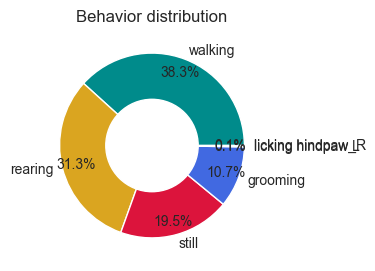

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# Pie Chart
ax.pie(df['values'], 
       colors=df['colors'], 
       labels=df['labels'],
       autopct='%1.1f%%', pctdistance=0.85)
# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
ax.set_title('Behavior distribution')
# Displaying Chart
plt.show()

### file save, change the extension to change the file format

In [11]:
fig.savefig(f'../figures/habituation_example_distribution_'
            f'{selected_condition}.svg', 
            dpi=600, bbox_inches='tight')